In [46]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize

from scipy.stats import iqr

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u

data = np.load('../../../source_synphot/caspec_mags.npy',allow_pickle=True).item()
data = pd.DataFrame(data)
red = np.load('../../../source_synphot/caspec_mags_av3p1.npy',allow_pickle=True).item()
red = pd.DataFrame(red)

ind = (data['r'].values-data['i'].values) < 0.3
from astropy.stats import sigma_clip

good = []
for i in range(len(data['name'])):
    if 'ngc6681' not in data['name'].iloc[i]:
        good += [i]
good = np.array(good)
data = data.iloc[good]
gr = data['g'].values-data['r'].values
ind = (gr < 1)
data = data.iloc[ind]

try to correct offset 

In [24]:
data['g'] += 0.02935
data['r'] += 0.01566
data['i'] += 0.00957
data['z'] += 0.00582

In [47]:
import sys
sys.path.append('../../../source_synphot/')
from tools import *

def mag2flux(mag,zp):
    f = 10**(2/5*(zp-mag))
    return f

def r_comp(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    r = -2.5*np.log10(fit) + 25 + re
    return r


def r_linear_combo2(c,mag):
    g = mag2flux(mag['g'],zp)
    i = mag2flux(mag['i'],zp)
    fit = (0.5*g + 0.5*i)*(g/i)**c[0]
    return fit 

def r_minimizer(c,mag,ext=None):
    k = mag['r']
    fit = r_comp(c,mag,ext=ext)
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

In [48]:
obs = pd.read_csv('../../../source_synphot/K2_all_PS1_psc_ev_crowding_sdss_gaia.csv')

obs = obs.iloc[(obs['PDC'].values > 0)]

obs['kMeanPSFMag'] = -2.5*np.log10(obs['PDC'].values)
obs['kMeanPSFMagErr'] = 0.01#(-2.5 / np.log(10)) * (obs['PDCe'].values / obs['PDC'].values) #0.05#np.abs(obs['PDCe'].values) / np.abs(obs['PDC'].values)/10
diff = abs(obs['rMeanPSFMag'].values - obs['crMeanPSFMag'].values)
ind = diff < 1

obs = obs.iloc[ind]

ind = ((abs(obs['zMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['gMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['rMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['iMeanPSFMagErr'].values) < 0.5))
obs = obs.iloc[ind]

g = obs['gMeanPSFMag'].values
r = obs['rMeanPSFMag'].values
i = obs['iMeanPSFMag'].values
z = obs['zMeanPSFMag'].values

ind = (g-r < 0.9)
obs = obs.iloc[ind]
mags = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

In [66]:
obs = pd.read_csv('../../../source_synphot/K2_all_PS1_psc_ev_crowding_sdss_gaia.csv')

In [72]:
bayestar = BayestarQuery()
coords = SkyCoord(obs.RAJ2000.values*u.deg,obs.DecJ2000.values*u.deg,
                  distance=obs.gaia_med.values*u.pc, frame='icrs')
med = bayestar(coords, mode='median')

coords = SkyCoord(obs.RAJ2000.values*u.deg,obs.DecJ2000.values*u.deg,
                  distance=obs.gaia_low.values*u.pc, frame='icrs')
low = bayestar(coords, mode='median')

coords = SkyCoord(obs.RAJ2000.values*u.deg,obs.DecJ2000.values*u.deg,
                  distance=obs.gaia_high.values*u.pc, frame='icrs')
high = bayestar(coords, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 42.812 s
  pix_info:   0.713 s
   samples:  29.398 s
      best:   4.955 s
       nan:   0.722 s
      sort:   6.799 s
       idx:   0.224 s


In [73]:
obs['ext_med'] = med
obs['ext_low'] = low
obs['ext_high'] = high

In [74]:
obs.to_csv('../../../source_synphot/K2_all_PS1_psc_ev_crowding_sdss_gaia_ext.csv',index=False)

In [50]:
c0 = [.3,.3,.3,1]
bds = [(0,1),(0,1),(0,1),(-100,100)]

thing = pd.DataFrame(data)

x_cal = minimize(r_minimizer,c0,args=thing,bounds=bds).x

thing = pd.DataFrame(mags)
x_ps1 = minimize(r_minimizer,c0,args=(mags,med),bounds=bds).x

In [51]:
c_ps1 = r_comp(x_ps1,mags,med)
c_cal = r_comp(x_cal,mags,med)

cal_diff = mags['r'] - c_cal
ps1_diff = mags['r'] - c_ps1
m = ~sigma_clip(cal_diff).mask & ~sigma_clip(ps1_diff).mask

In [52]:
c16 = obs['campaign'].values == 16
c4 = obs['campaign'].values == 4

In [53]:
mags['g'][c16]

array([14.97459984, 15.7894001 , 15.9406004 , ..., 14.51889992,
       15.88920021, 14.92739964])

<IPython.core.display.Javascript object>


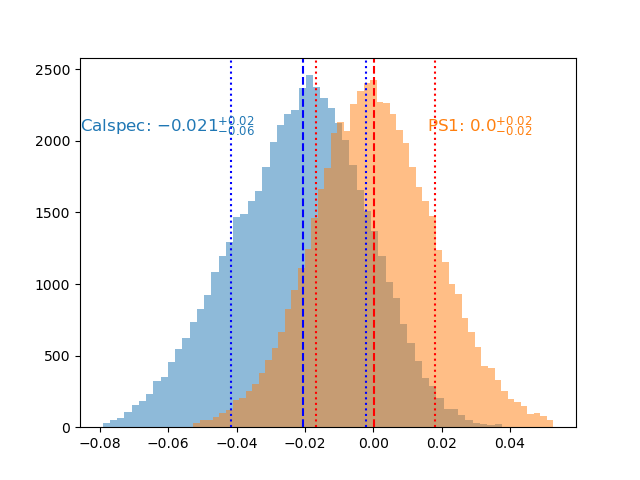

Text(0.7, 0.8, 'PS1: $0.0^{+0.02}_{-0.02}$')

In [54]:
plt.figure()
b = int(np.nanmax(cal_diff[m]) - np.nanmin(cal_diff[m]) /(2*iqr(cal_diff[m])*len(cal_diff[m])**(-1/3)))
a = plt.hist(cal_diff[m],bins=b,alpha=.5)

med = np.percentile(cal_diff[m],50)
low = np.percentile(cal_diff[m],16)
high = np.percentile(cal_diff[m],84)

plt.axvline(med,ls='--',color='b')
plt.axvline(low,ls=':',color='b')
plt.axvline(high,ls=':',color='b')

s = 'Calspec: $'+str(np.round(med,3))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(0.001,.8),fontsize=12,xycoords='axes fraction',color='C0')


a = plt.hist(ps1_diff[m],bins=b,alpha=.5)

med = np.percentile(ps1_diff[m],50)
low = np.percentile(ps1_diff[m],16)
high = np.percentile(ps1_diff[m],84)

plt.axvline(med,ls='--',color='r')
plt.axvline(low,ls=':',color='r')
plt.axvline(high,ls=':',color='r')


s = 'PS1: $'+str(np.round(med,3))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.7,.8),fontsize=12,xycoords='axes fraction',color='C1')


#a = plt.hist(ps1_diff[c16 & m],bins=b,alpha=.5)
#a = plt.hist(ps1_diff[c4 & m],alpha=.5)

<IPython.core.display.Javascript object>


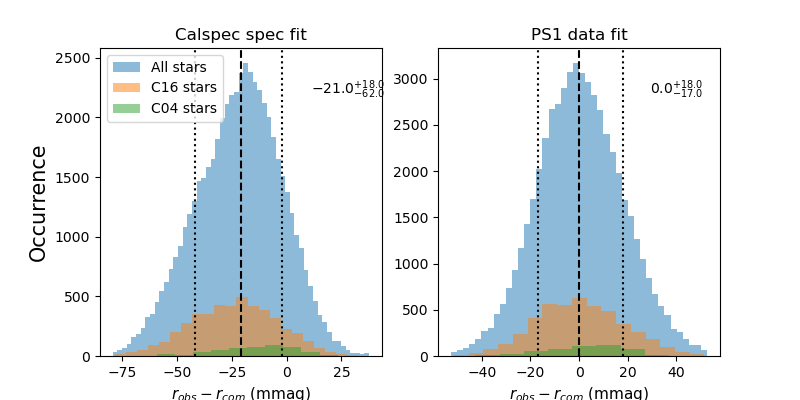

Text(0.5, 0, '$r_{obs}-r_{com}$ (mmag)')

In [55]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('Calspec spec fit')
b = int(np.nanmax(cal_diff[m]) - np.nanmin(cal_diff[m]) /(2*iqr(cal_diff[m])*len(cal_diff[m])**(-1/3)))
a = plt.hist(cal_diff[m]*1e3,bins=b, alpha=0.5,label='All stars')

b = int(np.nanmax(cal_diff[m & c16]) - np.nanmin(cal_diff[m & c16]) /(2*iqr(cal_diff[m & c16])*len(cal_diff[m & c16])**(-1/3)))
a = plt.hist(cal_diff[m & c16]*1e3,bins=b, alpha=0.5,label='C16 stars')

b = int(np.nanmax(cal_diff[m & c4]) - np.nanmin(cal_diff[m & c4]) /(2*iqr(cal_diff[m & c4])*len(cal_diff[m & c4])**(-1/3)))
a = plt.hist(cal_diff[m & c4]*1e3,bins=b, alpha=0.5,label='C04 stars')

med = np.percentile(cal_diff[m]*1e3,50)
low = np.percentile(cal_diff[m]*1e3,16)
high = np.percentile(cal_diff[m]*1e3,84)


plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,0))+'^{+' + str(np.round(high-med,0))+'}_{'+str(np.round(low+med,0))+'}$'
plt.annotate(s,(.75,.85),fontsize=10,xycoords='axes fraction')

plt.legend(loc=2)
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mmag)',fontsize=11)


plt.subplot(122)
plt.title('PS1 data fit')
b = int(np.nanmax(ps1_diff[m]) - np.nanmin(ps1_diff[m]) /(2*iqr(ps1_diff[m])*len(ps1_diff[m])**(-1/3)))
a = plt.hist(ps1_diff[m]*1e3,bins=b, alpha=0.5,label='All stars')

b = int(np.nanmax(ps1_diff[m & c16]) - np.nanmin(ps1_diff[m & c16]) /(2*iqr(ps1_diff[m & c16])*len(ps1_diff[m & c16])**(-1/3)))
a = plt.hist(ps1_diff[m & c16]*1e3,bins=b, alpha=0.5,label='C16 stars')

b = int(np.nanmax(ps1_diff[m & c4]) - np.nanmin(ps1_diff[m & c4]) /(2*iqr(ps1_diff[m & c4])*len(ps1_diff[m & c4])**(-1/3)))
a = plt.hist(ps1_diff[m & c4]*1e3,bins=b, alpha=0.5,label='C04 stars')

med = np.percentile(ps1_diff[m]*1e3,50)
low = np.percentile(ps1_diff[m]*1e3,16)
high = np.percentile(ps1_diff[m]*1e3,84)


plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,0))+'^{+' + str(np.round(high-med,0))+'}_{'+str(np.round(low+med,0))+'}$'
plt.annotate(s,(.75,.85),fontsize=10,xycoords='axes fraction')


plt.xlabel('$r_{obs}-r_{com}$ (mmag)',fontsize=11)


#plt.savefig('deltar_fit_comapre.png', bbox_inches = "tight")


In [56]:
def fudgefactor(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge+c[4],zp)
    i = mag2flux(mag['i']-ie+c[5],zp)
    z = mag2flux(mag['z']-ze+c[6],zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    r = -2.5*np.log10(fit) + 25 + re
    return r

def fudge_fit(c,mag,ext=None):
    k = mag['r']
    fit = fudgefactor(c,mag,ext=ext)
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

In [60]:
c0 = [.3,.3,.3,1,0.01,0.01,0.01]
bds = [(0,1),(0,1),(0,1),(-100,100),(-.1,.1),(-.1,.1),(-.1,.1)]

thing = pd.DataFrame(data)

x_cal2 = minimize(fudge_fit,c0,args=thing,bounds=bds).x

In [61]:
x_cal2

array([ 0.01628113,  0.71234238,  0.36046078,  0.43676156,  0.09297618,
       -0.09999994, -0.0022013 ])

In [64]:
c_ps1 = r_comp(x_ps1,mags,med)
c_cal = fudgefactor(x_cal2,mags,med)

cal_diff = mags['r'] - c_cal
ps1_diff = mags['r'] - c_ps1
m = ~sigma_clip(cal_diff).mask & ~sigma_clip(ps1_diff).mask

<IPython.core.display.Javascript object>


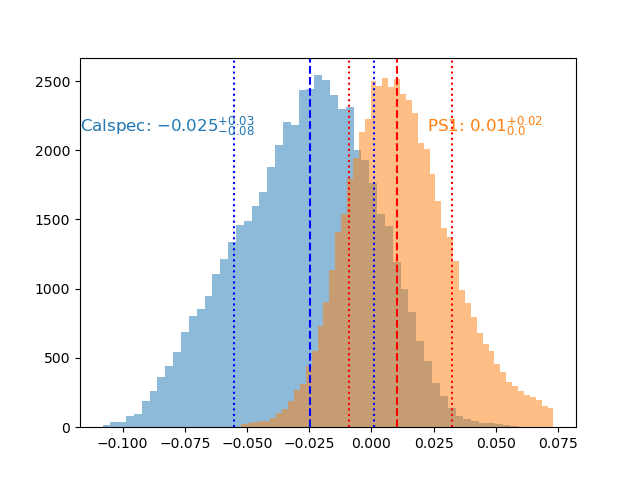

Text(0.7, 0.8, 'PS1: $0.01^{+0.02}_{0.0}$')

In [65]:
plt.figure()
b = int(np.nanmax(cal_diff[m]) - np.nanmin(cal_diff[m]) /(2*iqr(cal_diff[m])*len(cal_diff[m])**(-1/3)))
a = plt.hist(cal_diff[m],bins=b,alpha=.5)

med = np.percentile(cal_diff[m],50)
low = np.percentile(cal_diff[m],16)
high = np.percentile(cal_diff[m],84)

plt.axvline(med,ls='--',color='b')
plt.axvline(low,ls=':',color='b')
plt.axvline(high,ls=':',color='b')

s = 'Calspec: $'+str(np.round(med,3))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(0.001,.8),fontsize=12,xycoords='axes fraction',color='C0')


a = plt.hist(ps1_diff[m],bins=b,alpha=.5)

med = np.percentile(ps1_diff[m],50)
low = np.percentile(ps1_diff[m],16)
high = np.percentile(ps1_diff[m],84)

plt.axvline(med,ls='--',color='r')
plt.axvline(low,ls=':',color='r')
plt.axvline(high,ls=':',color='r')


s = 'PS1: $'+str(np.round(med,3))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.7,.8),fontsize=12,xycoords='axes fraction',color='C1')


#a = plt.hist(ps1_diff[c16 & m],bins=b,alpha=.5)
#a = plt.hist(ps1_diff[c4 & m],alpha=.5)